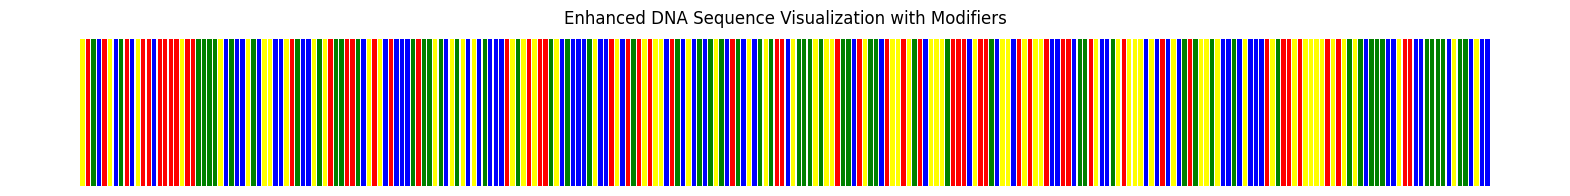

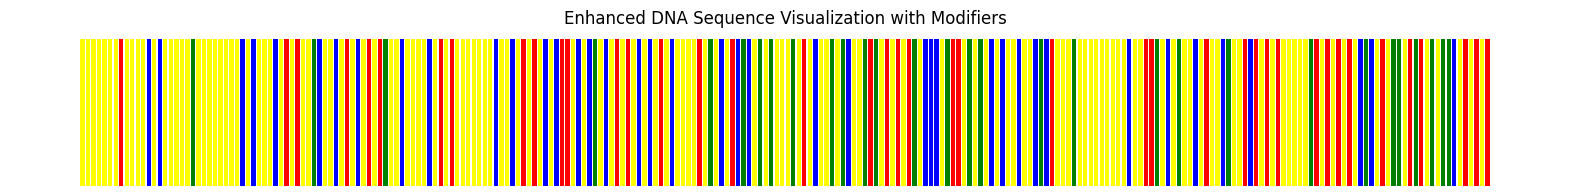

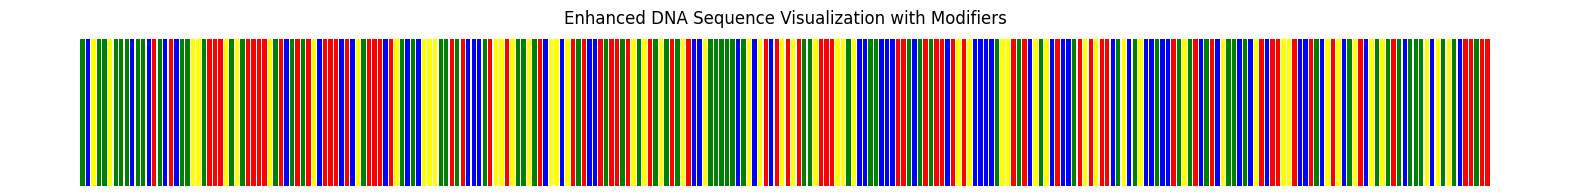

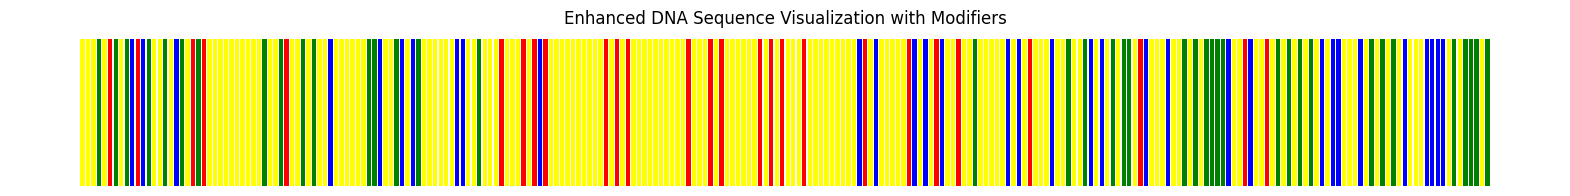

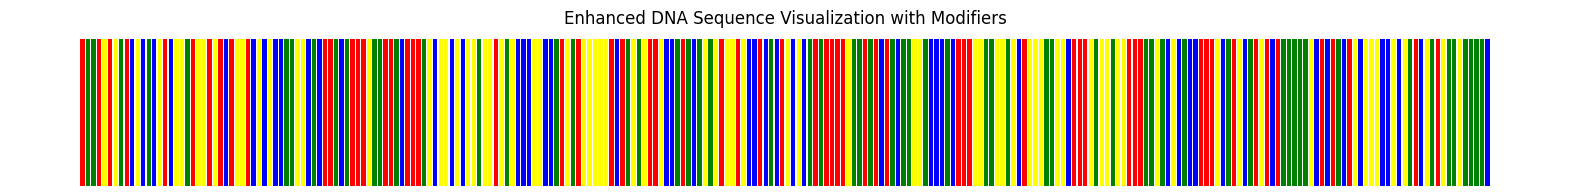

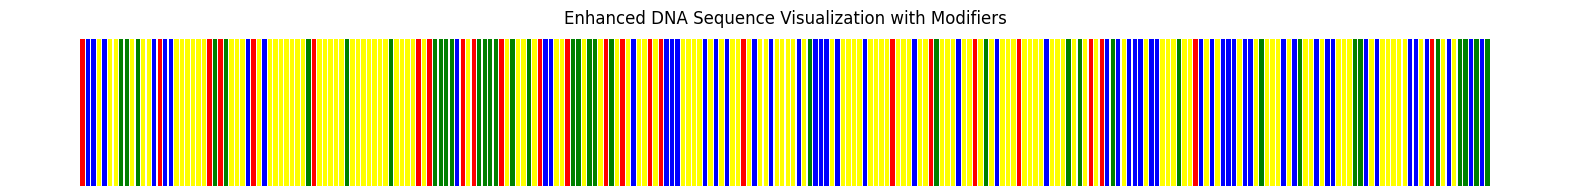

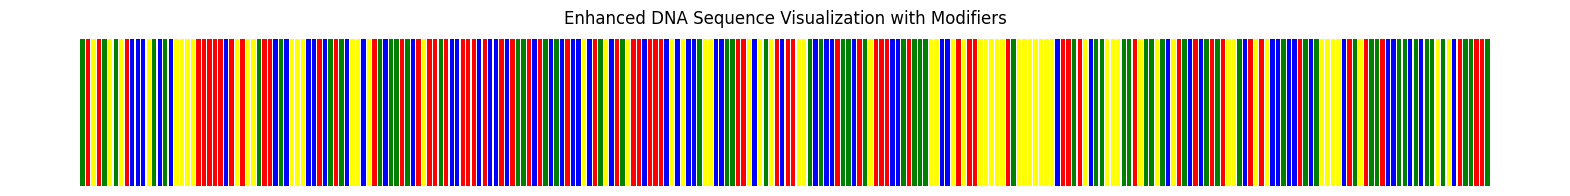

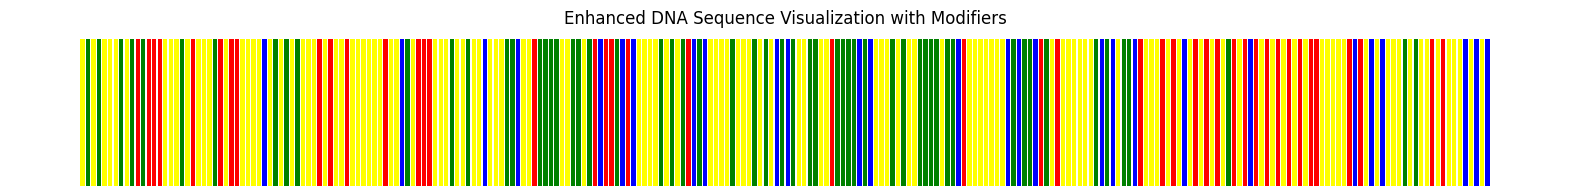

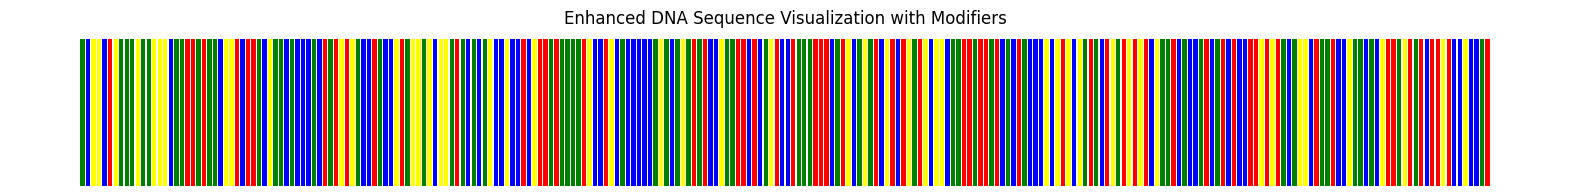

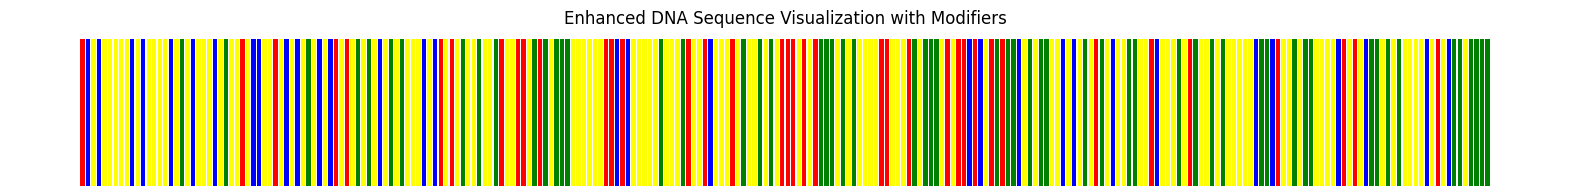

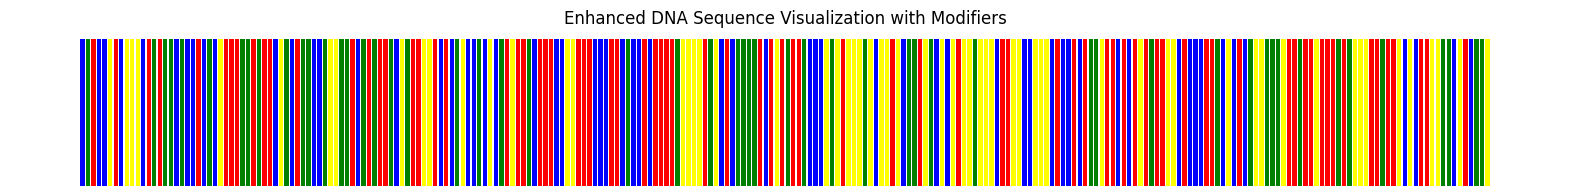

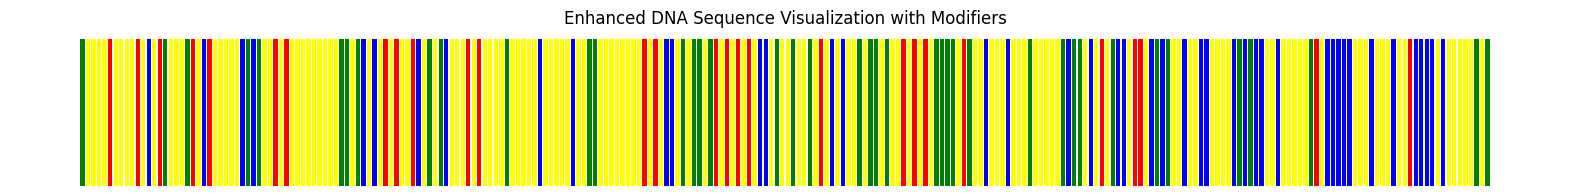

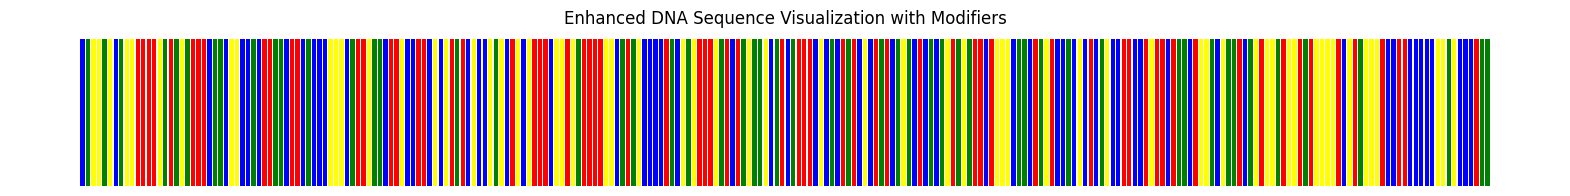

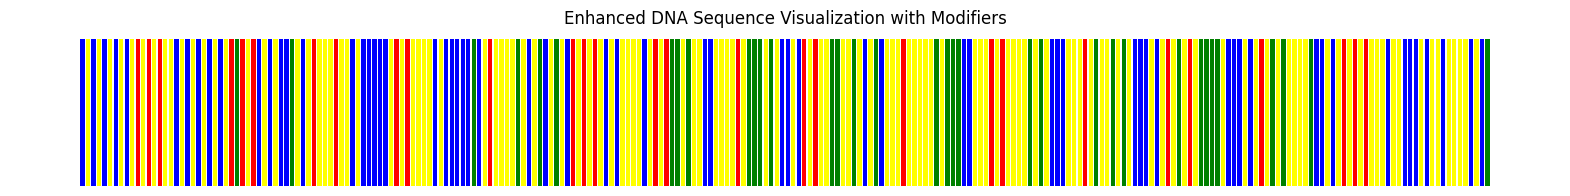

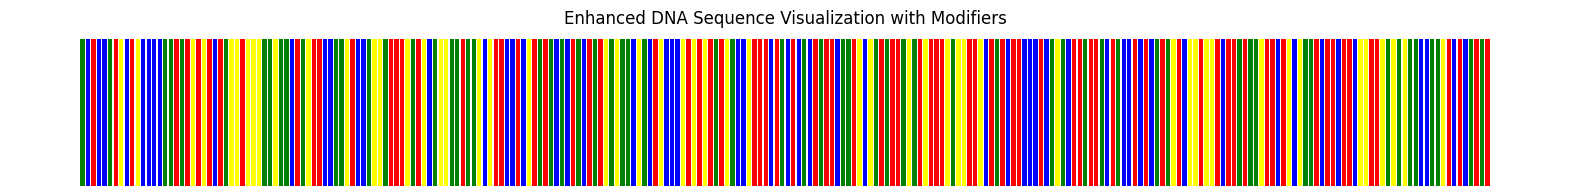

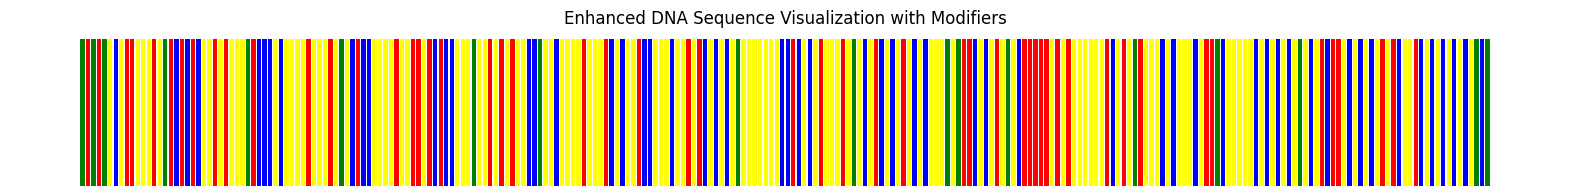

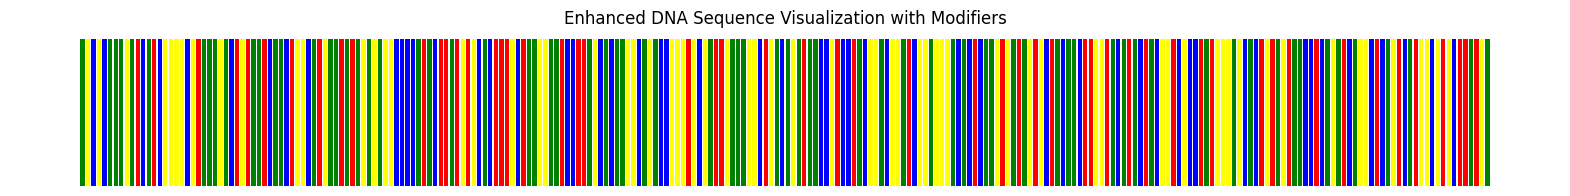

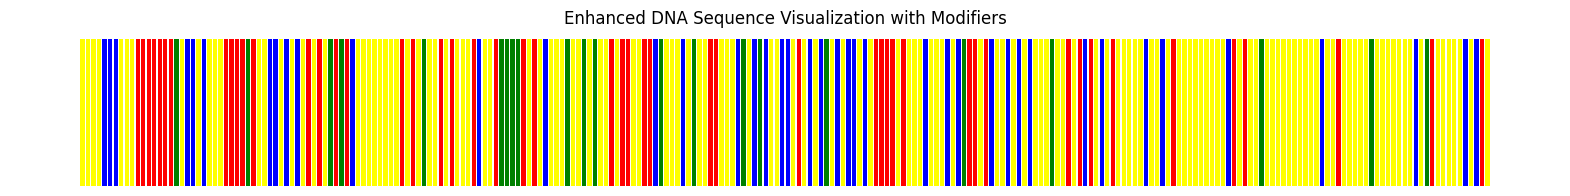

KeyboardInterrupt: 

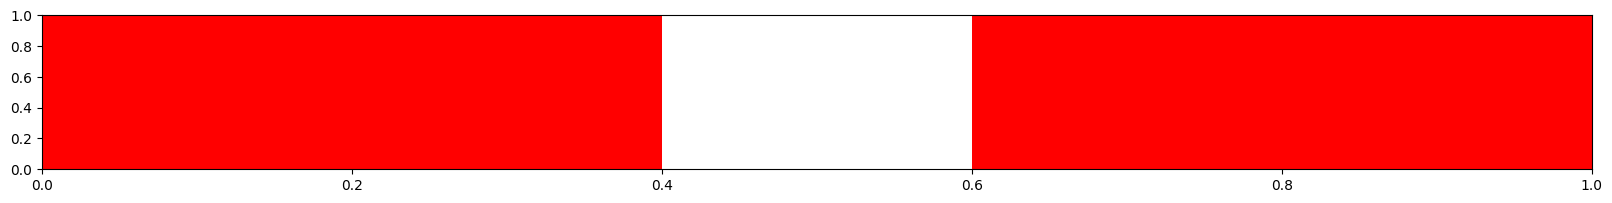

In [3]:
# combining a transformer with a cellular automata: dna sim
from dna_ca import DNA_CA
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F

batch_size = 2
block_size = 32
max_iter = 1000
eval_interval = 50
learning_rate = 5e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embed = 32
n_head = 2
n_layer = 2
dropout = 0.01
text = []
torch.manual_seed(100)

# create dictionaries and then define unique characters for encoding and decoding
tokens = ['A', 'T', 'C', 'G', '0', '1']

def generate_random_input_string(size):
    """Generate a random grid as a string for a given grid size."""
    return ''.join(np.random.choice(tokens, size*size))

# Example usage with cellular automata
grid_size = 16  # Grid size for the cellular automata
step_count = 10  # Number of steps to evolve the cellular automata

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[c] for c in s]
dec = lambda l: ''.join([itos[i] for i in l])

#  train and test splits
def get_validation_batch(val_initial_states, val_final_states, block_size):
    X_val = torch.tensor([enc(s)[:block_size] for s in val_initial_states], dtype=torch.long)
    Y_val = torch.tensor([enc(s)[:block_size] for s in val_final_states], dtype=torch.long)
    return X_val.to(device), Y_val.to(device)

def generate_random_input_string(size):
    """Generate a random grid as a string for a given grid size."""
    return ''.join(np.random.choice(tokens, size*size))

def generate_ATCG_sequence(batch_size, grid_size, step_count):
    initial_states = [generate_random_input_string(grid_size) for _ in range(batch_size)]
    final_states = []
    for state in initial_states:
        game = DNA_CA(grid_size, grid_size, step_count)
        final_state_array = game.run_simulation()  # This might be an array or complex structure
        # Process final_state_array to convert to a string sequence
        final_state_str = ''.join(final_state_array.flatten())  # Adjust based on the actual structure
        final_states.append(final_state_str)
    return initial_states, final_states

# Define an appropriate size for your validation batch
val_batch_size = 20

# load data
def get_batch(batch_size, grid_size, step_count, block_size):
    initial_states, final_states = generate_ATCG_sequence(batch_size, grid_size, step_count)
    X = torch.tensor([enc(s)[:block_size] for s in initial_states], dtype=torch.long)
    Y = torch.tensor([enc(s)[:block_size] for s in final_states], dtype=torch.long)
    return X.to(device), Y.to(device)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.ReLU(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x)) # add x for residual connections
        x = x + self.ffwd(self.ln1(x))
        return x

# bigram language model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1)  # Flatten targets to [batch_size * block_size]
            loss = F.cross_entropy(logits, targets)
            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx, idx_next), dim = 1)
        return idx
    
model = LanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
loss = None  # Initialize loss variable outside the loop

for iter in range(max_iter):
    model.train()
    xb, yb = get_batch(batch_size, grid_size, step_count, block_size)
    logits, loss = m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if iter % eval_interval == 0 and loss is not None:  # Check if 'loss' is defined
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Ensure no gradients are computed during evaluation
            xv, yv = get_batch(val_batch_size, grid_size, step_count, block_size)  # Dynamically generate validation data
            val_logits, val_loss = model(xv, yv)
            print(f"Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
        model.train()  # Reset the model to training mode


In [ ]:
# Generate a sequence
import numpy as np
import matplotlib.pyplot as plt

input_sequence = "ATCG"
context = torch.tensor(enc(input_sequence), dtype=torch.long, device=device).unsqueeze(0)
output = model.generate(context, max_new_tokens=4*len(input_sequence))
generated_text_t = dec(output[0].tolist())
simulator = DNA_CA(grid_length=len(input_sequence), grid_width=len(input_sequence), generations=step_count)
automata_grid = simulator.run_simulation()
generated_text_ca = simulator.save_grid_to_file(automata_grid)

def visualize_grid_with_modifiers(grid):
    """Visualise the grid."""
    base_colors = {'A': 'red', 'T': 'blue', 'C': 'green', 'G': 'yellow', '0': 'grey', '1': 'black'}
    colors = []
    for row in grid:
        row_colors = [base_colors[base] for base in row]
        colors.extend(row_colors)

    plt.figure(figsize=(20, 2))
    plt.bar(range(len(colors)), np.ones(len(colors)), color=colors)
    plt.axis('off')
    plt.title('Visualization with Modifiers')
    plt.show()

print(f"\nGenerated from CA is: {generated_text_ca}\n")
print(f"\nGenerated from T is: {generated_text_t}\n")
visualize_grid_with_modifiers(generated_text_ca)
visualize_grid_with_modifiers(generated_text_t)

In [ ]:
# Transformer GAN

generator_model = LanguageModel().to(device)
evaluator_model = LanguageModel().to(device)

for iter in range(max_iter):
    # Generator phase
    xb, _ = get_batch('train')  # Get real data batch
    generated_seqs = generator_model.generate(xb, max_new_tokens=block_size)  # Generate sequences
    
    # Evaluator phase: Evaluate generated sequences
    evaluator_loss = compute_evaluator_loss(evaluator_model, generated_seqs, real_data_indicator=False)
    # Update the evaluator model based on its ability to evaluate generated sequences
    optimizer_evaluator.zero_grad()
    evaluator_loss.backward()
    optimizer_evaluator.step()
    
    # Update generator based on evaluator feedback
    generator_feedback_loss = -evaluator_loss  # Using negative loss as an example to encourage fooling the evaluator
    optimizer_generator.zero_grad()
    generator_feedback_loss.backward()
    optimizer_generator.step()

    if iter % eval_interval == 0:
        # Estimate loss and log details
